In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from scipy import sparse
sys.path.append("..")
from spykesim import editsim
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
%matplotlib inline

In [2]:

def genpoisson_spiketrain(rate, dt, duration):
    offset = duration
    events = np.cumsum(np.random.exponential(scale = 1 / rate, size = int(duration*rate + offset)))
    return np.round(events[np.logical_and(0 < events, events < duration)], -int(np.log10(dt)))

def genpoisson_spiketrains(nneurons, rate, dt, duration):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    for n in range(nneurons):
        spike_train = genpoisson_spiketrain(rate, dt, duration)
        spike_timings = np.r_[spike_timings, spike_train]
        spike_neurons = np.r_[spike_neurons, n * np.ones_like(spike_train, dtype = np.int)]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    })

def gen_sequence(nneurons = 10, seqlen = 0.1, dt = 0.001):
    return np.round(np.linspace(dt, seqlen-dt, nneurons), int(-np.log10(dt)))

def gen_sequences(neurons = np.arange(10), nsequences = 10, start = 0, end = 60, seqlen = 0.1, dt = 0.001, shrink = 1):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    nneurons = len(neurons)
    sequence_onsets = np.random.choice(
        np.arange(start, end - seqlen, seqlen),
        nsequences,
        replace = False
    )
    for onset in sequence_onsets:
        spike_timings = np.r_[spike_timings, onset + gen_sequence(nneurons, seqlen / shrink, dt)]
        spike_neurons = np.r_[spike_neurons, neurons]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    }) 

def gen_sequences_with_replay(shrinkages = [2], neurons = np.arange(10), nsequences = 10, duration = 60, seqlen = 0.1, dt = 0.001):
    duration_per_type = duration / (len(shrinkages) + 1)
    sequences = gen_sequences(neurons,
                              nsequences,
                              0,
                              duration_per_type,
                              seqlen,
                              dt)
    for idx, shrinkage in enumerate(shrinkages):
        replay = gen_sequences(neurons,
                               nsequences,
                               duration_per_type * (idx + 1),
                               duration_per_type * (idx + 2),
                               seqlen,
                               dt, 
                               abs(shrinkage))
        if shrinkage < 0: # reverse replay
            replay = pd.DataFrame({
                "neuronid": replay.neuronid,
                "spiketime": np.copy(replay.spiketime[::-1])
            })
        sequences = pd.concat([sequences, replay])
    return sequences

In [3]:
dt = 0.001
# nsequences = 10
# seqlen = 0.3
nsequences = 5
seqlen = 0.1
shrinkages = [-5, 5]
nneurons = 10
duration = nsequences * seqlen * (len(shrinkages) + 1) + 0.2
nseqkinds = 3
df = pd.DataFrame()
for idx in range(nseqkinds):
    df_seq = gen_sequences_with_replay(
        shrinkages = shrinkages,
        neurons = np.arange(nneurons*(idx), nneurons*(idx+1)),
        nsequences = nsequences,
        duration = duration,
        seqlen = seqlen,
        dt = dt)
    df_seq = pd.DataFrame({
        "neuronid": df_seq.neuronid,
        "spiketime": np.copy(df_seq.spiketime + duration * idx + idx)
    })
    df = pd.concat([df, df_seq])

rate = 1
nneurons = nneurons*nseqkinds 
duration = duration*nseqkinds + nseqkinds
df_noise = genpoisson_spiketrains(nneurons, rate, dt, duration)
df = pd.concat([df, df_noise])

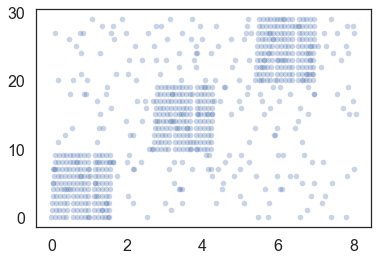

In [4]:
plt.plot(df.spiketime, df.neuronid, "b.", alpha = 0.3)

In [5]:
def df2binarray_csc(df, duration_ms = int(df.spiketime.max()*1000), binwidth = 1):
    neuronids = df.neuronid
    spikes_ms = df.spiketime * 1000
    nneurons = int(neuronids.max()+1)
    nrow = nneurons 
    ncol = int(duration_ms) // binwidth + 1000
    binarray_lil = sparse.lil_matrix((nrow, ncol))
    for neuronid in range(nneurons):
        spike_train_of_a_neuron = spikes_ms[neuronids == neuronid]
        bins = np.arange(0, ncol * binwidth, binwidth)
        digitized_spike_train_of_a_neuron = np.digitize(spike_train_of_a_neuron, bins) - 1
        binned_spike_train_of_a_neuron = np.bincount(digitized_spike_train_of_a_neuron)
        binarray_lil[neuronid, digitized_spike_train_of_a_neuron] = binned_spike_train_of_a_neuron[digitized_spike_train_of_a_neuron]
    return binarray_lil.tocsc()

In [6]:
from matplotlib import gridspec

binarray_csc = df2binarray_csc(df, duration_ms=int(duration*1000), binwidth = 1)
binmat = binarray_csc.toarray()

In [7]:
window = int(seqlen*1000)
a = 0.01

In [8]:
window = int(seqlen*1000)
a = 0.01
simmat_lsh, times = editsim.eval_simmat(binarray_csc, window, window//2, a = a, lsh=True, njobs=10, numband=20, bandwidth=5)

[2018-08-27 14:19:03,898] [MainThread] Execution of a function _get_nonzero_indices starts
[2018-08-27 14:19:03,968] [MainThread] submit end
[2018-08-27 14:19:03,972] [MainThread] Progress of the calculation
100%|██████████| 178/178 [00:00<00:00, 2.05kit/s]
[2018-08-27 14:19:04,079] [MainThread] Progress of the aggregation
178it [00:00, 126497.14it/s]
[2018-08-27 14:19:04,084] [MainThread] calculation end
[2018-08-27 14:19:04,088] [MainThread] Execution of a function Unknown starts
[2018-08-27 14:19:04,170] [MainThread] submit end
[2018-08-27 14:19:04,174] [MainThread] Progress of the calculation
100%|██████████| 178/178 [00:00<00:00, 1.31kit/s]
[2018-08-27 14:19:04,330] [MainThread] Progress of the aggregation
178it [00:00, 138307.91it/s]
[2018-08-27 14:19:04,334] [MainThread] calculation end
[2018-08-27 14:19:04,454] [MainThread] Execution of a function _eval_simvec_lsh starts
[2018-08-27 14:19:05,086] [MainThread] submit end
[2018-08-27 14:19:05,089] [MainThread] Progress of the cal

In [9]:
simmat_full, times = editsim.eval_simmat(binarray_csc, window, window//2, a = a, lsh=False, njobs=10, numband=20, bandwidth=5)

[2018-08-27 14:19:12,057] [MainThread] Execution of a function _eval_simvec starts
[2018-08-27 14:19:15,421] [MainThread] submit end
[2018-08-27 14:19:15,426] [MainThread] Progress of the calculation
100%|██████████| 178/178 [00:23<00:00, 7.57it/s]
[2018-08-27 14:19:38,973] [MainThread] Progress of the aggregation
178it [00:00, 183707.21it/s]
[2018-08-27 14:19:38,977] [MainThread] calculation end


In [10]:
diff = simmat_lsh.toarray() - simmat_full

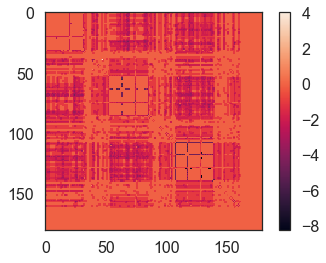

In [11]:
plt.imshow(diff)
plt.colorbar()

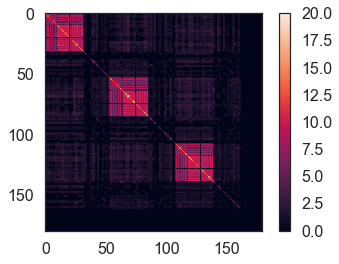

In [12]:
plt.imshow(simmat_full, vmin=0, vmax=20)
plt.colorbar()

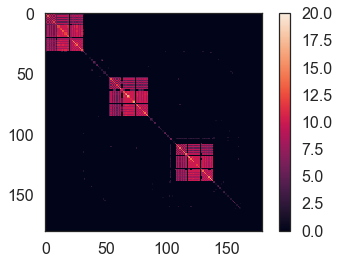

In [13]:
plt.imshow(simmat_lsh.toarray(), vmin=0, vmax=20)
plt.colorbar()